## <center> House Price - Best Approach Taken

In [1]:
#Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV, ElasticNet
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

#Handle warnings
import warnings
warnings.filterwarnings('ignore')

#Set precision to 4 decimals
%precision 4

'%.4f'

In [2]:
#Read dataset
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
#Review train data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#Review test data
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
#Review shape of dataset
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

## Backup the original data as we might mess it up in the process

In [6]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

#### Different ways to find Numerical and Categorical columns

In [113]:
catg_feats = df_train.select_dtypes(include='object').columns #Replace include by exclude for numerical features
catg_feats1 = df_train.dtypes[df_train.dtypes == 'object'].index #Change == by != for numerical features
catg_feats == catg_feats1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

### Find Null Values

In [102]:
def FindNulls(df_temp):
    noofrows = df_temp.shape[0]
    totalnas = df_temp.isnull().sum().sort_values(ascending=False)
    percent = round(df_temp.isnull().sum().sort_values(ascending=False)/noofrows*100,2)
    return pd.concat([totalnas, percent], keys=['Totalnas','Percentage'], axis=1)

df_temp = FindNulls(df_train)
df_temp.head()

,Totalnas,Percentage
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26


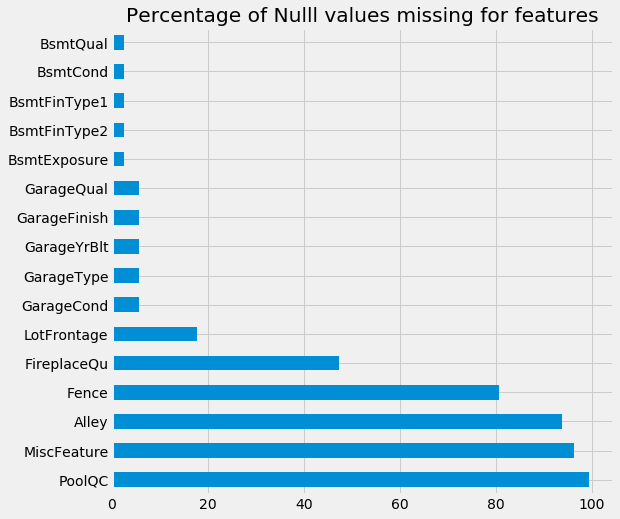

In [111]:
plt.figure(figsize=(8,8))
df_temp[df_temp['Percentage']>1]['Percentage'].plot(kind='barh')
plt.title('Percentage of Nulll values missing for features')
plt.show();

In [ ]:
c['SaleType']=c['SaleType'].fillna(method='ffill') ##Impute na by forward fill method

#### Drop null values when it is greater than 90%

In [101]:
df_temp = df_train.dropna(thresh = len(df_train)*0.9, axis=1)
print('No. of Columns dropped:', df_train.shape[1] - df_temp.shape[1])
print('Dropped Cols:', [col for col in df_train.columns if col not in df_temp.columns])

No. of Columns dropped: 6
Dropped Cols: ['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


### Different Visualizations

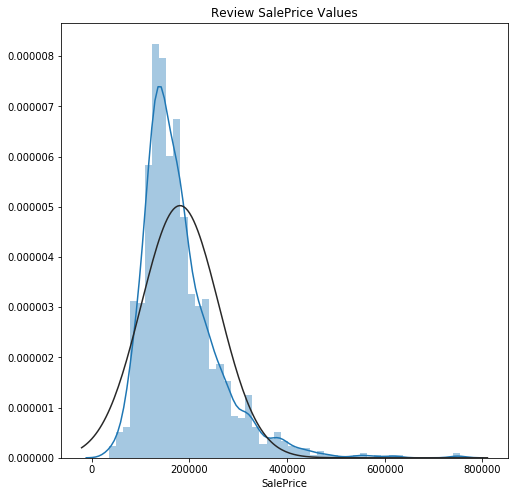

In [18]:
#Plot target variable
plt.figure(figsize=(8,8))
sb.distplot(df_train['SalePrice'], fit=norm)
plt.title('Review SalePrice Values')
plt.show();

In [28]:
# plt.figure(figsize=(6,5))
stats.probplot(df_train['SalePrice'], dist=norm)
plt.show()

In [35]:
print('Skewness of Target Variable:', df_train['SalePrice'].skew())
print('Kurtosis of Target Variable:', df_train['SalePrice'].kurt())

Skewness of Target Variable: 1.8828757597682129
Kurtosis of Target Variable: 6.536281860064529


#### Skewness

is the degree of distortion from the symmetrical bell curve or the normal curve.
So, a symmetrical distribution will have a skewness of "0".
<br>
<li> There are two types of Skewness: Positive and Negative.
<li> Positive Skewness(similar to our target variable distribution) means the tail on the right side of the distribution is longer and fatter.
<li> In positive Skewness the mean and median will be greater than the mode. This is similar to this dataset. So, in Layman's terms, more houses were sold by less than the average price.
<li> Negative Skewness means the tail on the left side of the distribution is longer and fatter.
<li> In negative Skewness the mean and median will be less than the mode.
<li>Skewness differentiates extreme values in one versus the other tail.
<img src=img/Skewness.jpeg>
    
#### Kurtosis

It is the measure of the extreme values(outliers) present in the distribution.
<br>
<li>There are three types of Kurtosis: Mesokurtic, Leptokurtic and Platykurtic.
<li>Mesokurtic is similar to normal curve with the standard value of 3. This means that the extreme values of this distrubution is similar to that of a normal distribution.
<li>Leptokurtic Example of leptokurtic distributions are the T-distributions with small degrees of freedom.
<li>Platykurtic: Platykurtic describes a particular statistical distribution with thinner tails than a normal distribution. Because this distribution has thin tails, it has fewer outliers (e.g., extreme values three or more standard deviations from the mean) than do mesokurtic and leptokurtic distributions.
<img src=img/KurtosisPict.jpg
    
Credits - https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing

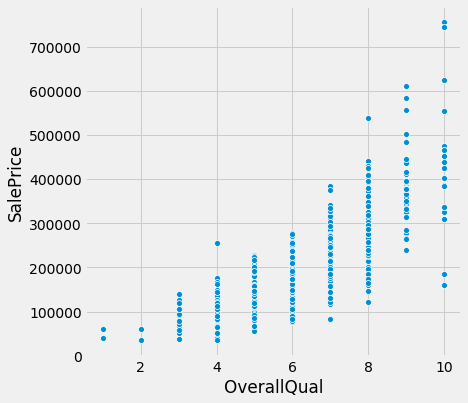

In [16]:
#Scatter Plot
from matplotlib import style

def ScatterPlot(x, y):
    style.use('fivethirtyeight')
    plt.subplots(figsize=(6,6))
    sb.scatterplot(x=x, y=y)
    plt.show();
    
ScatterPlot(df_train.OverallQual, df_train.SalePrice)

OverallQual is a categorical variable

**Heteroscedasticity:** <br>
<li>The relationship between the independent variables and the dependent variable is unequal across all values of the independent variable.
<li> An unequal level of variance across most predictor(independent) variable values and is a red flag for the multiple linear regression model.
<li>We assume that the variability in the response(dependent) variable doesn't increase as the value of the predictor(independent) increases, which is the assumptions of equal variance, also known as Homoscedasticity.
<li>We also assume that the observations are independent of one another(No Multicollinearity).
<li>One way to fix this Heteroscedasticity is by using a transformation method like log-transformation or box-cox transformation.
<br>
    
**Homoscedasticity ( Constant Variance ):**
<li>The relationship between the independent variables and the dependent variable is same across all values of the independent variable. 
<li>In other words, there is a constant variance present in the response variable as the predictor variable increases.
    <li> If the "noise" is not the same across the values of an independent variable like the residual plot above, we call that Heteroscedasticity.
<br>
        <img src=img/Homoscedasticity.png>

<br>

**Linearity**<br>
<li>Linear regression needs the relationship between each independent variable and the dependent variable to be linear. The linearity assumption can be tested with scatter plots.

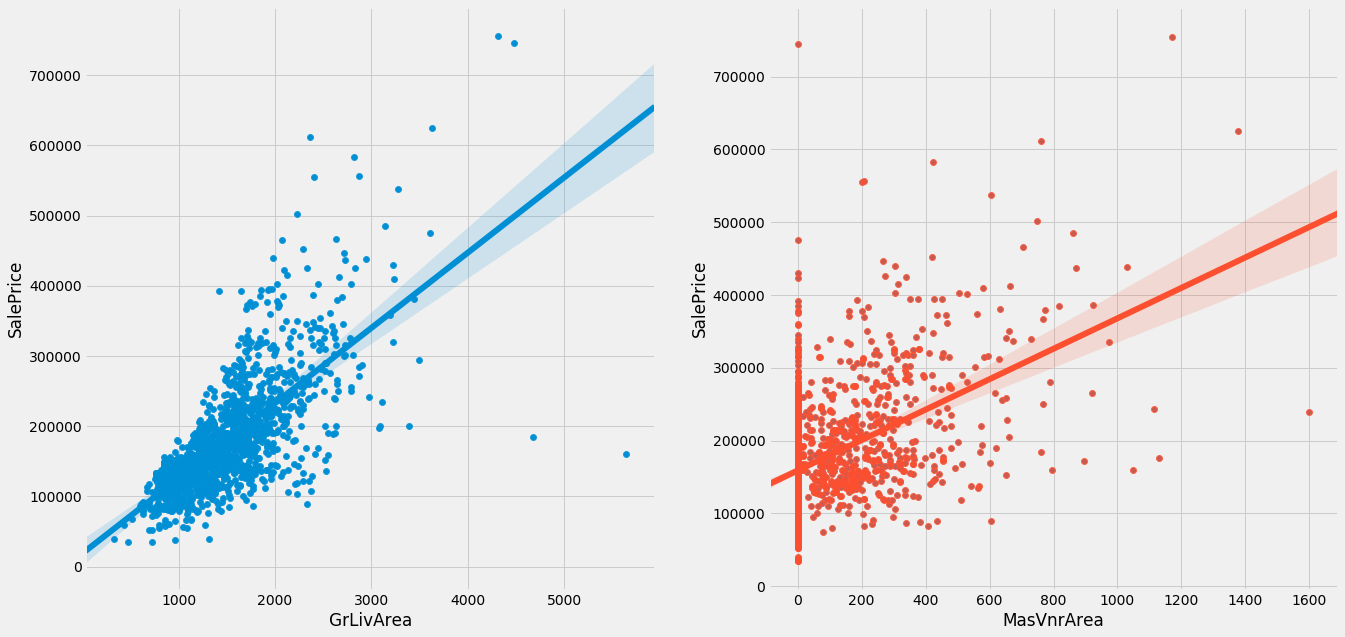

In [37]:
#Creating Subplots

#Defining subplots
fig, (ax1, ax2) = plt.subplots(figsize=(20,10), ncols=2, sharey=False)

#Building first plot
sb.scatterplot(df_train.GrLivArea, df_train.SalePrice, ax=ax1); #graph 1
sb.regplot(df_train.GrLivArea, df_train.SalePrice, ax=ax1); #graph 2

#Building second plot
sb.scatterplot(df_train.MasVnrArea, df_train.SalePrice, ax=ax2)
sb.regplot(df_train.MasVnrArea, df_train.SalePrice, ax=ax2);

**Observation** <br>
<li>It's pretty apparent from the chart that there is a better linear relationship between SalePrice and GrLivArea than SalePrice and MasVnrArea.
<li>Outliers in the dataset.
<li>Linear regression is sensitive to outlier effects.   

**Residual Plot**
<br>
<li>Tells us how is the error variance across the true line. 
<li>The error plot shows that as GrLivArea value increases the variance also increases, which is the characteristics known as Heteroscedasticity

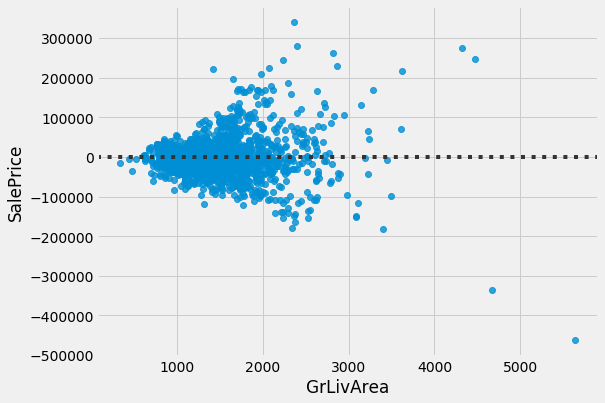

In [39]:
plt.figure(figsize=(8,6))
sb.residplot(df_train.GrLivArea, df_train.SalePrice)
plt.show();

**Multivariate Normality ( Normality of Errors):** <br>
<li>The linear regression analysis requires the dependent variable to be multivariate normally distributed. A histogram or a Q-Q-Plot can check whether the target variable is normally distributed or not. The goodness of fit test.

**No or Little multicollinearity:** <br>
Multicollinearity is when there is a strong correlation between independent variables. Linear regression or multilinear regression requires independent variables to have little or no similar features. Multicollinearity can lead to a variety of problems, including:<br><br>
<li>The effect of predictor variables estimated by our regression will depend on what other variables are included in our model.
<li>Predictors can have wildly different results depending on the observations in our sample, and small changes in samples can result in very different estimated effects.
<li>With very high multicollinearity, the inverse matrix, the computer calculates may not be accurate. 
<li>We can no longer interpret a coefficient on a variable as the effect on the target of a one-unit increase in that variable holding the other variables constant. The reason behind that is, when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.<br><br>
Heatmap is an excellent way to identify whether there is multicollinearity or not. The best way to solve multicollinearity is to use regularization methods like Ridge or Lasso.

### Heat Map

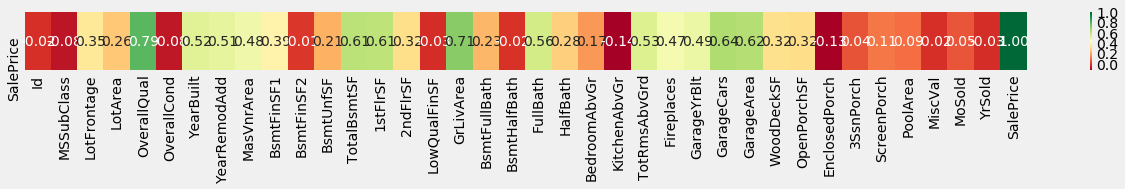

In [88]:
#Correlation Matrix
plt.figure(figsize=(20,1))
sb.heatmap(df_train.corr().sort_values(by='SalePrice').tail(1), cmap='RdYlGn', annot=True, fmt='.2f')
plt.show();

In [92]:
numcorr = df_train.corr()
numcorr['SalePrice'].sort_values(ascending=False).to_frame().T

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,BsmtFinSF2,BsmtHalfBath,MiscVal,Id,LowQualFinSF,YrSold,OverallCond,MSSubClass,EnclosedPorch,KitchenAbvGr
SalePrice,1.0,0.790982,0.708624,0.640409,0.623431,0.613581,0.605852,0.560664,0.533723,0.522897,...,-0.011378,-0.016844,-0.02119,-0.021917,-0.025606,-0.028923,-0.077856,-0.084284,-0.128578,-0.135907


In [96]:
#Correlation with gradient
cm = sb.light_palette('cyan', as_cmap=True)
nc = numcorr['SalePrice'].sort_values(ascending=False).to_frame()
nc = nc.style.background_gradient(cmap = cm)
nc

,SalePrice
SalePrice,1
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


### Subplots

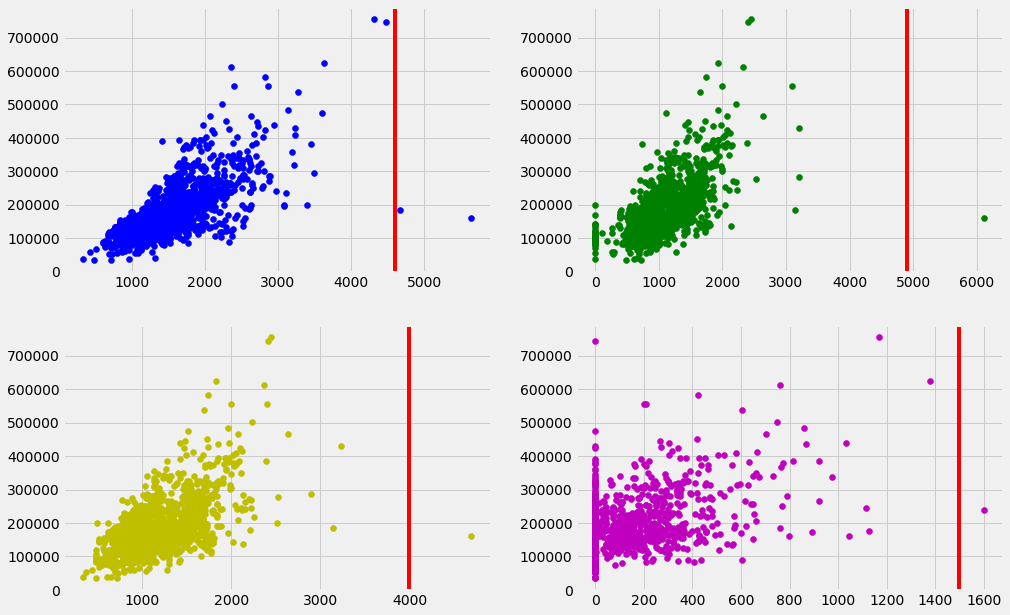

In [129]:
plt.figure(figsize=(15,10))

#Subplot 0,1
plt.subplot2grid((2,2), (0,0))
plt.scatter(df_train.GrLivArea, df_train.SalePrice, c='b')
plt.axvline(x=4600, c='r', linestyle='-')

#Subplot 0,2
plt.subplot2grid((2,2), (0,1))
plt.scatter(df_train.TotalBsmtSF, df_train.SalePrice, c='g')
plt.axvline(x=4900, c='r', linestyle='-')

#subplot(1, 0)
plt.subplot2grid((2,2), (1,0))
plt.scatter(df_train['1stFlrSF'], df_train.SalePrice, c='y')
plt.axvline(x=4000, c='r', linestyle='-')

#subplot(1, 1)
plt.subplot2grid((2,2), (1,1))
plt.scatter(df_train.MasVnrArea, df_train.SalePrice, c='m')
plt.axvline(x=1500, c='r', linestyle='-')

plt.show();

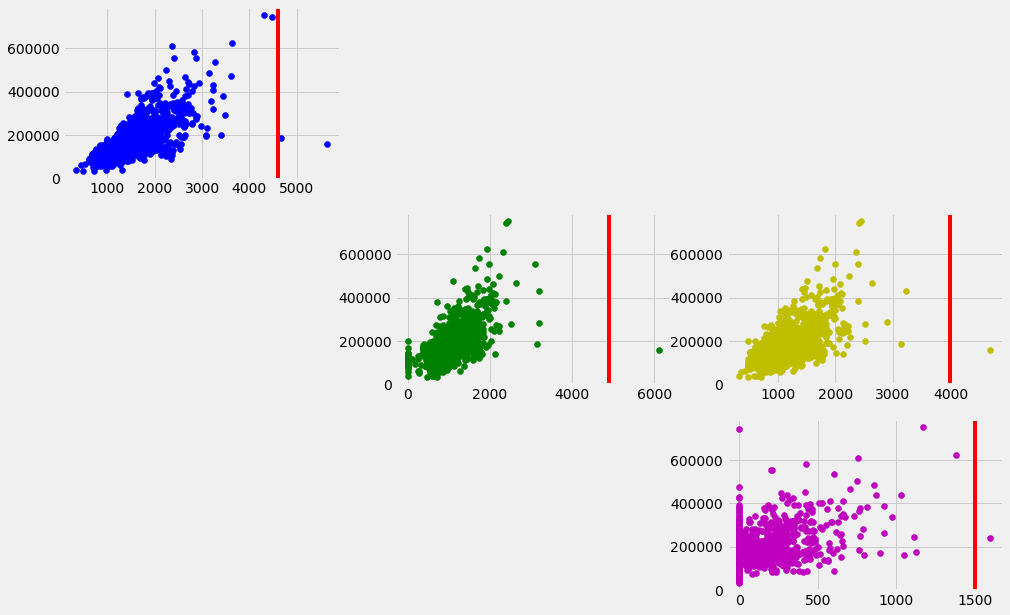

In [138]:
plt.figure(figsize=(15,10))

#Subplot 0,1
plt.subplot2grid((3,3), (0,0))
plt.scatter(df_train.GrLivArea, df_train.SalePrice, c='b')
plt.axvline(x=4600, c='r', linestyle='-')

#Subplot 0,2
plt.subplot2grid((3,3), (1,1))
plt.scatter(df_train.TotalBsmtSF, df_train.SalePrice, c='g')
plt.axvline(x=4900, c='r', linestyle='-')

#subplot(1, 0)
plt.subplot2grid((3,3), (1,2))
plt.scatter(df_train['1stFlrSF'], df_train.SalePrice, c='y')
plt.axvline(x=4000, c='r', linestyle='-')

#subplot(1, 1)
plt.subplot2grid((3,3), (2,2))
plt.scatter(df_train.MasVnrArea, df_train.SalePrice, c='m')
plt.axvline(x=1500, c='r', linestyle='-')

plt.show();

### Skewing Data

In [56]:
from scipy.stats import boxcox_normmax

def handle_skew(df_temp):
    #Separte the numerical features from dataset as skew only applies to them
    num_feats = df_temp.select_dtypes(exclude='object').columns
    skew_data = df_temp[num_feats].apply(lambda x: skew(x.dropna()))
    more_skewed = skew_data[abs(skew_data)>0.5]
    more_skewed = more_skewed.sort_values(ascending=False)
    print('No. of the features to be treated for skewness:', len(more_skewed.index))
    
    #Fixing skewness
    for col in more_skewed.index:
        df_temp[col] = boxcox1p(df_temp[col], boxcox_normmax(df_temp[col]+1))
        
    return df_temp

df_temp = handle_skew(df_temp)

No. of the features to be treated for skewness: 15


## Function to find overfit columns

In [70]:
def Find_OverFit_Cols(df_temp):
    overfit_cols = []
    
    for col in df_temp.columns:
        uniqvals = df_temp[col].value_counts()
        cntoffirstval = uniqvals.iloc[0]
        if cntoffirstval/len(df_temp)*100 > 99.94:
            overfit_cols.append(col)
    
    return overfit_cols

Find_OverFit_Cols(df_train_copy)
#Need to drop these columns

[]